In [1]:
import os
import numpy as np
from datetime import datetime
import h5py
import matplotlib.pyplot as plt

import asf_search as asf
import earthaccess

import rasterio
from rasterio.crs import CRS
from rasterio.transform import from_bounds
from rasterio.warp import reproject, Resampling

import shapely.wkt as wkt
from shapely.geometry import Point
from scipy.ndimage import uniform_filter

import geopandas as gpd
import requests

import rapidphase

/users/jinwook/miniconda3/envs/pytorch/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def setup_asf_session():
    """Set up ASF session using earthaccess authentication."""
    auth = earthaccess.login()
    session = asf.ASFSession()
    session.auth_with_creds(auth.username, auth.password)
    return session


def search_opera_datasets(session, start_date, end_date, operaBurstID=None):
    """Search for OPERA CSLC datasets."""
    start = datetime.strptime(start_date, '%Y-%m-%d')
    end = datetime.strptime(end_date, '%Y-%m-%d')
    
    search_params = {
        'dataset': asf.DATASET.OPERA_S1,
        'processingLevel': asf.PRODUCT_TYPE.CSLC,
        'start': start,
        'end': end,
    }
    if operaBurstID:
        search_params['operaBurstID'] = operaBurstID
    
    results = asf.geo_search(**search_params)
    print(f"Found {len(results)} datasets matching criteria")
    return results


def download_datasets(session, results, output_dir):
    """Download datasets to specified directory."""
    os.makedirs(output_dir, exist_ok=True)
    for i, result in enumerate(results, 1):
        print(f"Downloading {i}/{len(results)}: {result.properties['fileName']}")
        result.download(path=output_dir, session=session)

In [3]:
def cslc_read(input_hdf):
    """Read CSLC data from HDF5 file."""
    with h5py.File(input_hdf, 'r') as h5:
        cslc = h5['data/VV'][:]
        xcoor = h5['data/x_coordinates'][:]
        ycoor = h5['data/y_coordinates'][:]
        dx = h5['data/x_spacing'][()].astype(int)
        dy = h5['data/y_spacing'][()].astype(int)
        epsg = h5['data/projection'][()].astype(int)
        bounding_polygon = h5['identification/bounding_polygon'][()].astype(str)
        center_lon, center_lat = h5['metadata/processing_information/input_burst_metadata/center']
    return cslc, xcoor, ycoor, dx, dy, epsg, bounding_polygon, center_lon, center_lat


def rasterWrite(outtif, arr, transform, epsg, dtype='float32'):
    """Write array to GeoTIFF."""
    with rasterio.open(outtif, 'w', driver='GTiff',
                       height=arr.shape[0], width=arr.shape[1],
                       count=1, dtype=dtype,
                       crs=CRS.from_epsg(epsg),
                       transform=transform, nodata=np.nan) as dst:
        dst.write(arr, 1)

In [4]:
def estimate_coherence(ifg, pow1, pow2, window_size=11):
    """
    Estimate interferometric coherence.
    
    Coherence: gamma = |<s1*s2*>| / sqrt(<|s1|^2> * <|s2|^2>)
    
    Parameters
    ----------
    ifg : np.ndarray
        Complex interferogram (s1 * conj(s2))
    pow1, pow2 : np.ndarray
        Power of reference and secondary images
    window_size : int
        Size of averaging window
        
    Returns
    -------
    coh : np.ndarray
        Coherence values in [0, 1], NaN where invalid
    """
    valid = np.isfinite(ifg) & np.isfinite(pow1) & np.isfinite(pow2) & (pow1 > 0) & (pow2 > 0)
    
    ifg_clean = np.where(valid, ifg, 0.0)
    pow1_clean = np.where(valid, pow1.real, 0.0)
    pow2_clean = np.where(valid, pow2.real, 0.0)
    valid_float = valid.astype(np.float64)
    
    valid_count = uniform_filter(valid_float, size=window_size, mode='nearest')
    ifg_real_sum = uniform_filter(ifg_clean.real, size=window_size, mode='nearest')
    ifg_imag_sum = uniform_filter(ifg_clean.imag, size=window_size, mode='nearest')
    pow1_sum = uniform_filter(pow1_clean, size=window_size, mode='nearest')
    pow2_sum = uniform_filter(pow2_clean, size=window_size, mode='nearest')
    
    valid_count = np.maximum(valid_count, 1e-10)
    scale = 1.0 / valid_count
    
    mean_ifg = (ifg_real_sum + 1j * ifg_imag_sum) * scale
    mean_pow1 = pow1_sum * scale
    mean_pow2 = pow2_sum * scale
    
    coh = np.abs(mean_ifg) / np.sqrt(np.maximum(mean_pow1 * mean_pow2, 1e-10))
    coh = np.clip(coh, 0, 1)
    coh[valid_count < 0.1] = np.nan
    
    return coh


def download_worldcover(lon, lat, output_dir='worldcover', year=2021):
    """Download ESA WorldCover tile for given coordinates."""
    os.makedirs(output_dir, exist_ok=True)
    version = 'v200' if year == 2021 else 'v100'
    
    s3_url_prefix = "https://esa-worldcover.s3.eu-central-1.amazonaws.com"
    grid_url = f'{s3_url_prefix}/v100/2020/esa_worldcover_2020_grid.geojson'
    
    print("Downloading WorldCover grid file...")
    grid = gpd.read_file(grid_url)
    
    point = Point(lon, lat)
    containing_tile = grid[grid.contains(point)]
    
    if containing_tile.empty:
        raise ValueError(f"No WorldCover tile found for: lon={lon}, lat={lat}")
    
    tile_name = containing_tile.iloc[0].ll_tile
    file_name = f"ESA_WorldCover_10m_{year}_{version}_{tile_name}_Map.tif"
    url = f"{s3_url_prefix}/{version}/{year}/map/{file_name}"
    local_file = os.path.join(output_dir, file_name)
    
    if os.path.exists(local_file):
        print(f"WorldCover tile exists: {local_file}")
        return local_file
    
    print(f"Downloading WorldCover tile {tile_name}...")
    response = requests.get(url, allow_redirects=True)
    response.raise_for_status()
    
    with open(local_file, 'wb') as f:
        f.write(response.content)
    
    print(f"Downloaded: {local_file}")
    return local_file


def create_water_mask(shape, transform, crs, worldcover_file):
    """Create water mask from ESA WorldCover (class 80 = water)."""
    water_mask_data = np.zeros(shape, dtype=np.uint8)
    
    print("Reprojecting WorldCover...")
    with rasterio.open(worldcover_file) as src:
        reproject(
            source=rasterio.band(src, 1),
            destination=water_mask_data,
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=transform,
            dst_crs=crs,
            resampling=Resampling.nearest
        )
    
    water_mask = water_mask_data == 80
    water_pct = 100 * np.sum(water_mask) / water_mask.size
    print(f"Water mask: {np.sum(water_mask):,} pixels ({water_pct:.2f}%)")
    
    return water_mask

In [5]:
# Configuration
burstID = 'T124_264307_IW2'
start_date = '2023-10-14'
end_date = '2023-10-28'
asf_dir = 'asf_downloads'
output_dir = 'outputs'
os.makedirs(output_dir, exist_ok=True)

# Set up session and search for datasets
session = setup_asf_session()
results = search_opera_datasets(session, start_date, end_date, operaBurstID=burstID)

# Download datasets
list_hdf = []
if results:
    download_datasets(session, results, asf_dir)
    for result in results:
        list_hdf.append(f"{asf_dir}/{result.properties['fileName']}")
    list_hdf.sort()
    print(f"Downloads completed: {asf_dir}")
else:
    print("No datasets found.")

Found 2 datasets matching criteria
Downloads completed: asf_downloads


In [6]:
# Read CSLC data
refCSLC, xcoor, ycoor, dx, dy, epsg, bounding_polygon, center_lon, center_lat = cslc_read(list_hdf[0])
secCSLC, _, _, _, _, _, _, _, _ = cslc_read(list_hdf[1])

cslc_transform = from_bounds(
    xcoor[0], 
    ycoor[0] + (refCSLC.shape[0] - 1) * dy, 
    xcoor[0] + (refCSLC.shape[1] - 1) * dx, 
    ycoor[0], 
    refCSLC.shape[1], 
    refCSLC.shape[0]
)

# Compute interferogram
ifg = refCSLC * np.conj(secCSLC)
pow1 = refCSLC * np.conj(refCSLC)
pow2 = secCSLC * np.conj(secCSLC)
phase = np.angle(ifg)

ifgname = f'ifg_{burstID}_{start_date.replace("-","")}_{end_date.replace("-","")}'
print(f"Interferogram shape: {phase.shape}")

Interferogram shape: (4650, 20592)


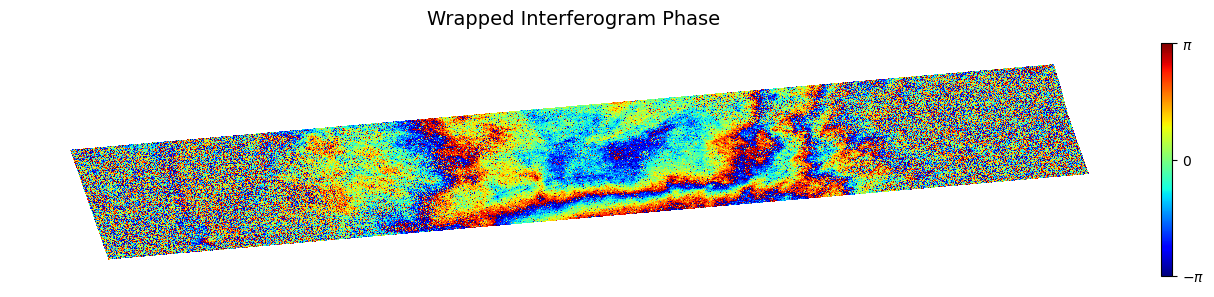

In [7]:
# Plot wrapped interferogram
fig, ax = plt.subplots(figsize=(15, 5))
cax = ax.imshow(phase, cmap='jet', interpolation='None', origin='upper', vmin=-np.pi, vmax=np.pi)
ax.set_title('Wrapped Interferogram Phase', fontsize=14)
ax.axis('off')
cbar = fig.colorbar(cax, orientation='vertical', fraction=0.01, pad=0.02)
cbar.set_ticks([-np.pi, 0., np.pi])
cbar.set_ticklabels([r'$-\pi$', '$0$', r'$\pi$'])
fig.savefig(f'{output_dir}/{ifgname}.png', dpi=300, bbox_inches='tight')
plt.show()

In [8]:
# Estimate coherence and create water mask
print("Estimating coherence...")
coh = estimate_coherence(ifg, pow1, pow2, window_size=11)

print("\nDownloading water mask...")
worldcover_file = download_worldcover(center_lon, center_lat, output_dir='worldcover')
water_mask = create_water_mask(
    shape=phase.shape,
    transform=cslc_transform,
    crs=CRS.from_epsg(epsg),
    worldcover_file=worldcover_file
)

# Apply coherence threshold and water mask
coh_thr = 0.4
igram = np.exp(1j * phase)
igram[coh < coh_thr] = np.nan
igram[np.isnan(coh)] = np.nan
igram[water_mask] = np.nan

print(f"\nCoherence range: [{np.nanmin(coh):.3f}, {np.nanmax(coh):.3f}]")

Estimating coherence...


/tmp/ipykernel_3312561/3181982763.py:21: RuntimeWarning: invalid value encountered in greater
  valid = np.isfinite(ifg) & np.isfinite(pow1) & np.isfinite(pow2) & (pow1 > 0) & (pow2 > 0)



Downloaded: worldcover/ESA_WorldCover_10m_2021_v200_N18W156_Map.tif
Reprojecting WorldCover...
Water mask: 2,514,907 pixels (2.63%)

Coherence range: [0.000, 0.998]


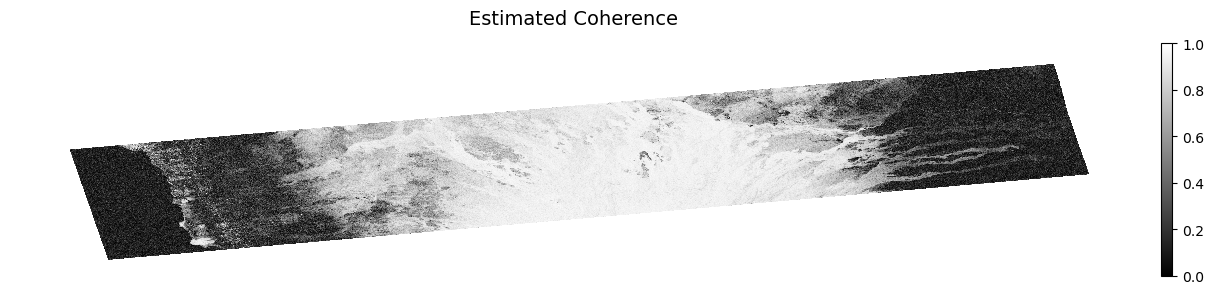

In [9]:
# Plot coherence
fig, ax = plt.subplots(figsize=(15, 5))
cax = ax.imshow(coh, cmap='gray', interpolation='None', origin='upper', vmin=0, vmax=1)
ax.set_title('Estimated Coherence', fontsize=14)
ax.axis('off')
fig.colorbar(cax, orientation='vertical', fraction=0.01, pad=0.02)
fig.savefig(f'{output_dir}/{ifgname}_coherence.png', dpi=300, bbox_inches='tight')
plt.show()

In [10]:
# Phase unwrapping with three algorithms
# DCT: fastest, unweighted
# IRLS: uses coherence weighting
# IRLS-CG: uses coherence weighting with faster convergence

print("Running DCT unwrapping...")
unw_dct, _ = rapidphase.unwrap(igram, algorithm='dct')

print("Running IRLS unwrapping...")
unw_irls, _ = rapidphase.unwrap(igram, corr=coh, algorithm='irls', nlooks=5.0, max_iterations=30)

print("Running IRLS-CG unwrapping...")
unw_irls_cg, _ = rapidphase.unwrap(igram, corr=coh, algorithm='irls_cg', nlooks=5.0, max_iterations=20)

print("Unwrapping complete!")

Running DCT unwrapping...
Running IRLS unwrapping...
Running IRLS-CG unwrapping...
Unwrapping complete!


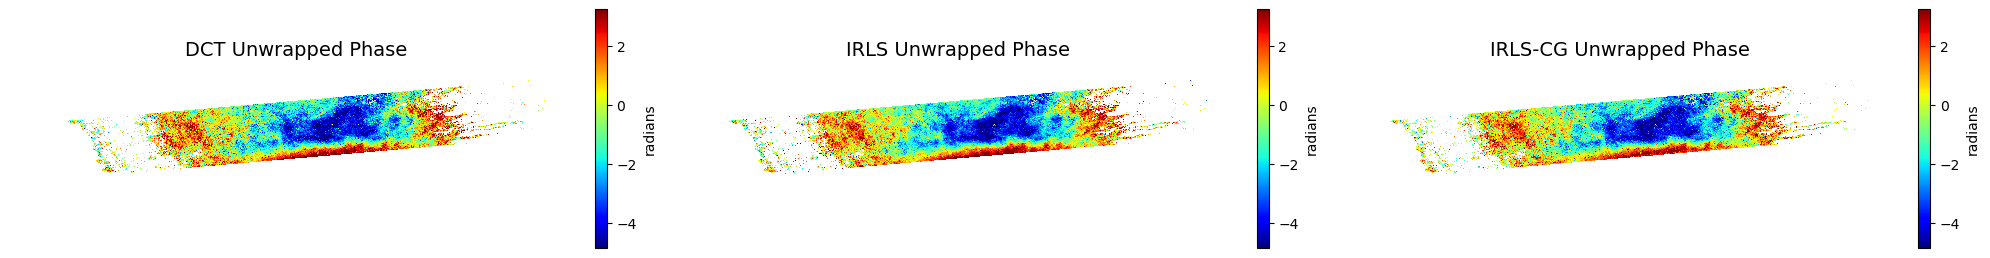

In [11]:
# Compare unwrapping results
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

titles = ['DCT', 'IRLS', 'IRLS-CG']
results = [unw_dct, unw_irls, unw_irls_cg]

vmin = np.nanpercentile(np.concatenate([r.flatten() for r in results]), 2)
vmax = np.nanpercentile(np.concatenate([r.flatten() for r in results]), 98)

for ax, title, unw in zip(axes, titles, results):
    im = ax.imshow(unw, cmap='jet', interpolation='None', origin='upper', vmin=vmin, vmax=vmax)
    ax.set_title(f'{title} Unwrapped Phase', fontsize=14)
    ax.axis('off')
    plt.colorbar(im, ax=ax, orientation='vertical', fraction=0.02, pad=0.02, label='radians')

plt.tight_layout()
fig.savefig(f'{output_dir}/{ifgname}_unwrap_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

In [12]:
# Apply Goldstein filter to reduce phase noise
# Use device='cpu' for large images to avoid GPU memory issues
print("Applying Goldstein filter...")

igram_for_filter = np.exp(1j * phase)
igram_filtered = rapidphase.goldstein_filter(
    igram_for_filter, 
    alpha=0.5, 
    window_size=32, 
    overlap=0.75,
    device='cuda'   # 'cuda' for GPU, 'cpu' for CPU, 'mps' for Apple Silicon
)

# Apply masks to filtered interferogram
igram_filtered[coh < coh_thr] = np.nan
igram_filtered[np.isnan(coh)] = np.nan
igram_filtered[water_mask] = np.nan

print("Filtering complete.")

Applying Goldstein filter...
Filtering complete.


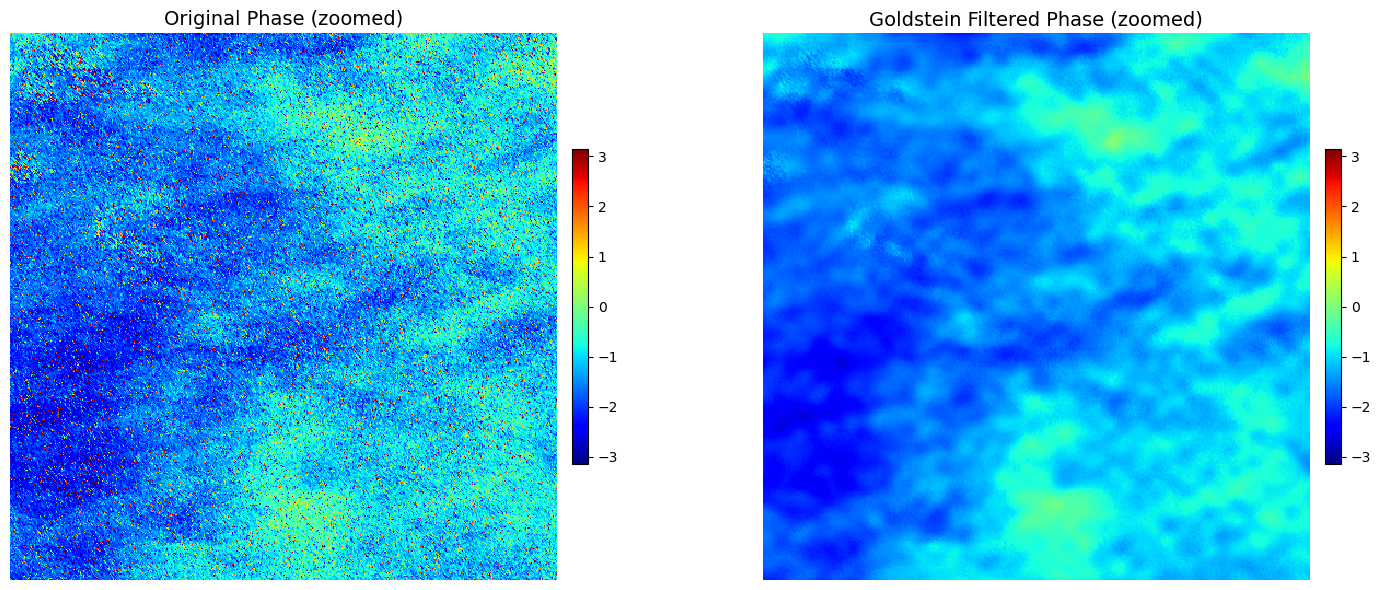

In [13]:
# Compare original vs filtered (zoomed region)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

row_slice = slice(2000, 2500)
col_slice = slice(10000, 10500)

ax1 = axes[0]
im1 = ax1.imshow(np.angle(igram[row_slice, col_slice]), cmap='jet', interpolation='None', 
                  origin='upper', vmin=-np.pi, vmax=np.pi)
ax1.set_title('Original Phase (zoomed)', fontsize=14)
ax1.axis('off')
plt.colorbar(im1, ax=ax1, orientation='vertical', fraction=0.02, pad=0.02)

ax2 = axes[1]
im2 = ax2.imshow(np.angle(igram_filtered[row_slice, col_slice]), cmap='jet', interpolation='None', 
                  origin='upper', vmin=-np.pi, vmax=np.pi)
ax2.set_title('Goldstein Filtered Phase (zoomed)', fontsize=14)
ax2.axis('off')
plt.colorbar(im2, ax=ax2, orientation='vertical', fraction=0.02, pad=0.02)

plt.tight_layout()
fig.savefig(f'{output_dir}/{ifgname}_filter_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

Unwrapping filtered interferogram...


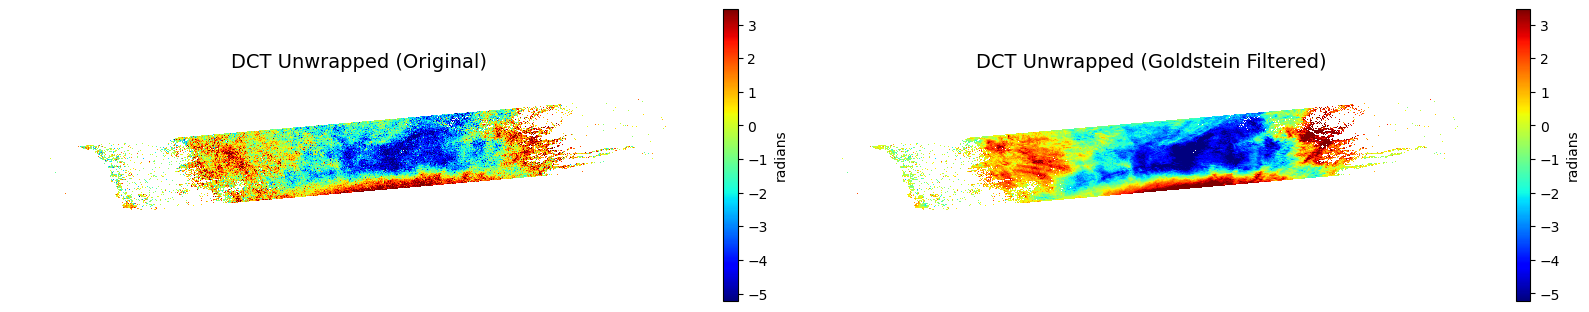

In [14]:
# Unwrap filtered interferogram
print("Unwrapping filtered interferogram...")
unw_filtered, _ = rapidphase.unwrap(igram_filtered, algorithm='dct')

# Compare unfiltered vs filtered
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

vmin = np.nanpercentile(np.concatenate([unw_dct.flatten(), unw_filtered.flatten()]), 2)
vmax = np.nanpercentile(np.concatenate([unw_dct.flatten(), unw_filtered.flatten()]), 98)

ax1 = axes[0]
im1 = ax1.imshow(unw_dct, cmap='jet', interpolation='None', origin='upper', vmin=vmin, vmax=vmax)
ax1.set_title('DCT Unwrapped (Original)', fontsize=14)
ax1.axis('off')
plt.colorbar(im1, ax=ax1, orientation='vertical', fraction=0.02, pad=0.02, label='radians')

ax2 = axes[1]
im2 = ax2.imshow(unw_filtered, cmap='jet', interpolation='None', origin='upper', vmin=vmin, vmax=vmax)
ax2.set_title('DCT Unwrapped (Goldstein Filtered)', fontsize=14)
ax2.axis('off')
plt.colorbar(im2, ax=ax2, orientation='vertical', fraction=0.02, pad=0.02, label='radians')

plt.tight_layout()
fig.savefig(f'{output_dir}/{ifgname}_filtered_unwrap_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

In [15]:
# Save results to GeoTIFF
print("Saving results...")

rasterWrite(f'{output_dir}/{ifgname}_unw_dct.tif', unw_dct.astype(np.float32), cslc_transform, epsg)
rasterWrite(f'{output_dir}/{ifgname}_unw_irls.tif', unw_irls.astype(np.float32), cslc_transform, epsg)
rasterWrite(f'{output_dir}/{ifgname}_unw_irls_cg.tif', unw_irls_cg.astype(np.float32), cslc_transform, epsg)
rasterWrite(f'{output_dir}/{ifgname}_unw_filtered.tif', unw_filtered.astype(np.float32), cslc_transform, epsg)
rasterWrite(f'{output_dir}/{ifgname}_coh.tif', coh.astype(np.float32), cslc_transform, epsg)

print(f"\nSaved to {output_dir}/")
print(f"  - {ifgname}_unw_dct.tif")
print(f"  - {ifgname}_unw_irls.tif")
print(f"  - {ifgname}_unw_irls_cg.tif")
print(f"  - {ifgname}_unw_filtered.tif")
print(f"  - {ifgname}_coh.tif")

Saving results...

Saved to outputs/
  - ifg_T124_264307_IW2_20231014_20231028_unw_dct.tif
  - ifg_T124_264307_IW2_20231014_20231028_unw_irls.tif
  - ifg_T124_264307_IW2_20231014_20231028_unw_irls_cg.tif
  - ifg_T124_264307_IW2_20231014_20231028_unw_filtered.tif
  - ifg_T124_264307_IW2_20231014_20231028_coh.tif
